In [774]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings

In [775]:
from featureExtraction import *
from dataAnalyzer import *
from private_tool import *
from dataHandler import *

In [776]:
warnings.filterwarnings('ignore')

In [777]:
experimentNum = 9
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [778]:
channels = list(range(25))
samplingRate = 250 #Hz
trialsByClasses = np.array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [779]:
for i in range(len(trialsByClasses)):
    for j in trialsByClasses[i].keys():
        for k in range(len(trialsByClasses[i][j])):
            for l in range(len(trialsByClasses[i][j][k])):
                trialsByClasses[i][j][k][l] = trialsByClasses[i][j][k][l][749:1500]


In [780]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(25, 25)

In [781]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=7, 
                                                                cutoff_high=30)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [782]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key: np.array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# i: experiment
# j: trial

In [783]:
minTrialsNum = sorted([sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["right"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["tongue"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["foot"][i][0]) for i in range(experimentNum)])[0]])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}
minTrialsNum

49

In [836]:
experimentIdx = 3

In [837]:
left_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["left"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
right_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["right"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
tongue_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["tongue"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
foot_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["foot"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))

In [838]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [839]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j[:minTrialsNum].T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j[:minTrialsNum].T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j[:minTrialsNum].T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j[:minTrialsNum].T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [840]:
len(CSP_passed_left_data)

25

In [841]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [842]:
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]
np.array(CSP_passed_left_data).shape

(25, 49, 751)

In [843]:
CSP_passed_left_data = np.array([i.T for i in np.array(CSP_passed_left_data).T]).T
CSP_passed_right_data = np.array([i.T for i in np.array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = np.array([i.T for i in np.array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = np.array([i.T for i in np.array(CSP_passed_foot_data).T]).T
CSP_passed_left_data.shape

(49, 25, 751)

In [844]:
m = 3

leftVarRatioDF = twoMDimensionalFeature(CSP_passed_left_data, channelNum, minTrialsNum, m)
rightVarRatioDF = twoMDimensionalFeature(CSP_passed_right_data, channelNum, minTrialsNum, m)
tongueVarRatioDF = twoMDimensionalFeature(CSP_passed_tongue_data, channelNum, minTrialsNum, m)
footVarRatioDF = twoMDimensionalFeature(CSP_passed_foot_data, channelNum, minTrialsNum, m)

VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
labelDF = pd.DataFrame([i for i in range(4) for j in range(minTrialsNum)])

VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:, 1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,4,5,target
0,-3.187912,-3.334346,-3.146940,-3.073776,-3.141091,-3.202319,0
1,-3.256387,-3.391802,-3.244328,-3.105354,-3.133606,-3.189190,0
2,-3.275862,-3.408879,-3.245254,-3.122513,-3.125232,-3.205207,0
3,-3.280840,-3.307364,-3.189071,-3.137607,-3.196959,-3.253788,0
4,-3.205725,-3.419641,-3.241752,-3.054101,-3.107288,-3.187569,0
...,...,...,...,...,...,...,...
191,-3.388729,-3.405265,-3.301346,-3.181447,-3.211759,-3.213440,3
192,-3.257734,-3.388283,-3.256941,-3.087026,-3.257203,-3.372706,3
193,-3.375756,-3.519571,-3.365083,-3.254964,-3.309648,-3.385572,3
194,-3.203683,-3.384883,-3.169307,-3.069329,-3.122659,-3.334096,3


In [845]:
x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5
0,1.019176,0.827367,1.466134,1.107617,0.737381,0.784330
1,0.438513,0.272724,0.404731,0.761947,0.820526,0.916769
2,0.273373,0.107877,0.394639,0.574117,0.913555,0.755195
3,0.231154,1.087835,1.006965,0.408898,0.116770,0.265109
4,0.868121,0.003988,0.432806,1.322987,1.112883,0.933122
...,...,...,...,...,...,...
191,-0.683723,0.142763,-0.216682,-0.070993,-0.047634,0.672135
192,0.427094,0.306694,0.267275,0.962577,-0.552459,-0.934535
193,-0.573711,-0.960677,-0.911332,-0.875744,-1.135042,-1.064333
194,0.885434,0.339519,1.222359,1.156297,0.942133,-0.545041


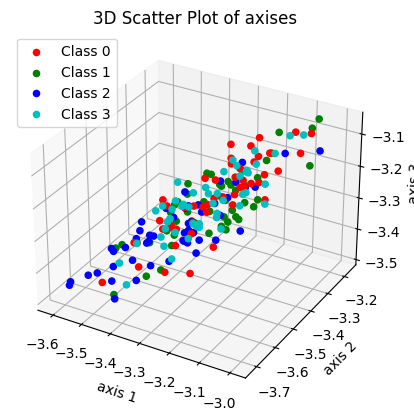

In [846]:
plotDF3D(data=VarRatioDF, num_of_classes=4)

In [847]:
cross_validation("linear", VarRatioDF.drop(['label'], axis=1).values , labelDF)
cross_validation("rbf", VarRatioDF.drop(['label'], axis=1).values , labelDF)

교차검증 평균:  0.3716666666666667
교차검증 평균:  0.33128205128205124


In [848]:
n_componunts = 3
PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
principalDF = PCA.principalDf

In [849]:
sum(PCA.explained_variance_ratio_())

0.948030973244365

In [850]:
cross_validation("linear", principalDF, labelDF)
cross_validation("rbf", principalDF, labelDF)

교차검증 평균:  0.3717948717948718
교차검증 평균:  0.3516666666666667


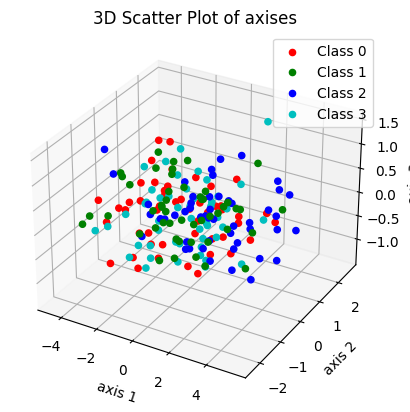

In [851]:
df = pd.concat([principalDF, labelDF], axis=1)
plotDF3D(data=df, num_of_classes=4)

In [852]:
np.save(currDir+"/test.npy", VarRatioDF)

In [853]:
LDA_DF = pd.concat([pd.DataFrame(LDATransform(x, labelDF, 3, "eigen")), labelDF], axis=1)
LDA_DF.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [854]:
cross_validation("linear", LDA_DF.loc[:,:"axis3"], labelDF)
cross_validation("rbf", LDA_DF.loc[:,:"axis3"], labelDF)

교차검증 평균:  0.36705128205128207
교차검증 평균:  0.3620512820512821


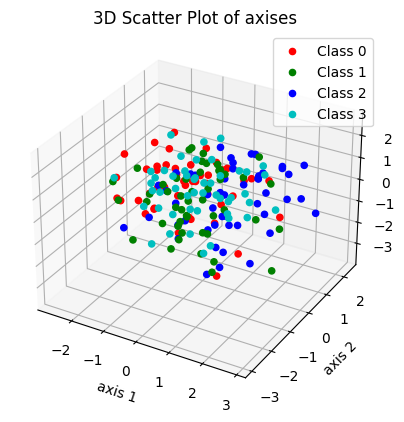

In [855]:
plotDF3D(data=LDA_DF, num_of_classes=4)

In [856]:
scaler = StandardScaler()
scaler.fit(LDA_DF.loc[:, :"axis3"])
LDA_DF_Scaled = pd.concat([pd.DataFrame(scaler.transform(LDA_DF.loc[:, :"axis3"])), labelDF], axis=1)
LDA_DF_Scaled.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [857]:
cross_validation("linear", LDA_DF_Scaled.loc[:,:"axis3"], labelDF)
cross_validation("rbf", LDA_DF_Scaled.loc[:,:"axis3"], labelDF)

교차검증 평균:  0.36705128205128207
교차검증 평균:  0.37743589743589745


In [858]:
np.save(currDir+"/test.npy", LDA_DF_Scaled)